In [1]:
import google.datalab.bigquery as bq
import google.datalab.storage as storage
from google.datalab import Context
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from scipy import stats

import xgboost
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.calibration import *
from sklearn.ensemble import *
from sklearn import svm
from sklearn.svm import *
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import pylift
from pylift.pylift.eval import UpliftEval

import warnings
warnings.filterwarnings('ignore')

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data Pull

##### Test: Pull 500K records from the test dataset and build out a dataframe

In [2]:
%%bq tables list

In [3]:
test_query="""
select *
from  `fit-reference-229502.test.test`
order by rand()
limit 500000
"""

In [4]:
test = bq.Query(test_query).execute().result().to_dataframe()

In [5]:
test.head()

,string_field_0,string_field_1,string_field_2,string_field_3,string_field_4,string_field_5,string_field_6,string_field_7,string_field_8,string_field_9,string_field_10,string_field_11,string_field_12,string_field_13,string_field_14,string_field_15
0,-0.5997576428618232,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,0.94516266118926673,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0
1,1.9919806210563484,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,2.9817208870630889,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0
2,1.9919806210563484,3.2636406358678913,9.2799535236626749,3.7358709424489791,3.5067331320159765,10.161280650613378,2.9817208870630889,-0.16668935847080157,-0.58439162045482274,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0
3,-1.8194784385821023,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,1.3677866777904817,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,0,0,0,0
4,1.9919806210563484,3.2636406358678913,8.88563056637241,3.7358709424489791,3.5067331320159765,10.161280650613378,2.9817208870630889,-0.16668935847080157,-6.0061605979960309,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0


In [6]:
test.columns = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','treatment','conversion','visit','exposure']

In [7]:
test.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,-0.5997576428618232,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,0.94516266118926673,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0
1,1.9919806210563484,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,2.9817208870630889,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0
2,1.9919806210563484,3.2636406358678913,9.2799535236626749,3.7358709424489791,3.5067331320159765,10.161280650613378,2.9817208870630889,-0.16668935847080157,-0.58439162045482274,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0
3,-1.8194784385821023,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,1.3677866777904817,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,0,0,0,0
4,1.9919806210563484,3.2636406358678913,8.88563056637241,3.7358709424489791,3.5067331320159765,10.161280650613378,2.9817208870630889,-0.16668935847080157,-6.0061605979960309,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0


In [8]:
test.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000
unique,243814,19,179631,312,87,48,842,19827,1649,697,15771,43,2,2,2,2
top,1.9919806210563484,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,2.9817208870630889,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0
freq,236025,495077,309197,428049,484132,480070,236025,480070,309197,417310,484132,494819,422757,498837,479176,482746


In [9]:
test = test.apply(pd.to_numeric)

In [10]:
test.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,0.616469,3.265672,8.507219,3.656055,3.522623,10.201858,1.753108,-0.293906,-2.060263,10.672677,-2.091726,4.159094,0.845514,0.002326,0.041648,0.034508
std,1.535216,0.022796,0.358967,0.242385,0.109021,0.232451,1.674301,0.666010,5.472115,2.296307,1.378917,0.016964,0.361414,0.048173,0.199784,0.182530
min,-1.946272,3.263641,8.272483,1.551137,3.506733,10.161281,-7.629779,-4.724469,-31.897883,9.850093,-13.038239,4.157648,0.000000,0.000000,0.000000,0.000000
25%,-1.007858,3.263641,8.272483,3.735871,3.506733,10.161281,0.945163,-0.166689,-2.716012,9.850093,-1.860900,4.157648,1.000000,0.000000,0.000000,0.000000
50%,1.626206,3.263641,8.272483,3.735871,3.506733,10.161281,2.386066,-0.166689,1.107571,9.850093,-1.860900,4.157648,1.000000,0.000000,0.000000,0.000000
75%,1.991981,3.263641,8.757223,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.860900,4.157648,1.000000,0.000000,0.000000,0.000000
max,1.991981,4.267414,9.337054,3.735871,6.956245,16.664351,2.981721,-0.166689,1.107571,29.903633,-1.860900,5.172055,1.000000,1.000000,1.000000,1.000000


In [11]:
test = test.iloc[:, 0:14]

In [12]:
test.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion
0,-0.599758,3.263641,8.272483,3.735871,3.506733,10.161281,0.945163,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0
1,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0
2,1.991981,3.263641,9.279954,3.735871,3.506733,10.161281,2.981721,-0.166689,-0.584392,9.850093,-1.8609,4.157648,1,0
3,-1.819478,3.263641,8.272483,3.735871,3.506733,10.161281,1.367787,-0.166689,1.107571,9.850093,-1.8609,4.157648,0,0
4,1.991981,3.263641,8.885631,3.735871,3.506733,10.161281,2.981721,-0.166689,-6.006161,9.850093,-1.8609,4.157648,1,0


##### Train: Pull 1.5MM records from the train dataset and build out a dataframe

In [13]:
sampling_query="""
select *
from  `fit-reference-229502.train.train`
order by rand()
limit 1500000
"""

In [14]:
rdf = bq.Query(sampling_query).execute().result().to_dataframe()

In [15]:
rdf.head()

,string_field_0,string_field_1,string_field_2,string_field_3,string_field_4,string_field_5,string_field_6,string_field_7,string_field_8,string_field_9,string_field_10,string_field_11,string_field_12,string_field_13,string_field_14,string_field_15
0,0.7707184846213293,3.2636406358678913,8.615077571572435,3.4717418848979587,4.6063060242366127,10.161280650613378,1.3677866777904817,-0.16668935847080157,-14.233238720776377,16.894055870712954,-5.4837136935776618,4.4425740218254157,1,0,0,0
1,-1.7167306815574044,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,1.1413291202681113,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0
2,0.64754014140830085,3.2636406358678913,8.6362749598716242,3.3172362908797912,3.5067331320159765,10.161280650613378,1.3677866777904817,-0.16668935847080157,-7.0125040768072218,15.043962417054203,-1.8608999471198722,4.1576480474015156,1,0,0,0
3,1.9919806210563484,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,2.9817208870630889,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0
4,-1.0574277452858132,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,1.3677866777904817,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0


In [16]:
rdf.columns = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','treatment','conversion','visit','exposure']

In [17]:
rdf.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,0.7707184846213293,3.2636406358678913,8.615077571572435,3.4717418848979587,4.6063060242366127,10.161280650613378,1.3677866777904817,-0.16668935847080157,-14.233238720776377,16.894055870712954,-5.4837136935776618,4.4425740218254157,1,0,0,0
1,-1.7167306815574044,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,1.1413291202681113,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0
2,0.64754014140830085,3.2636406358678913,8.6362749598716242,3.3172362908797912,3.5067331320159765,10.161280650613378,1.3677866777904817,-0.16668935847080157,-7.0125040768072218,15.043962417054203,-1.8608999471198722,4.1576480474015156,1,0,0,0
3,1.9919806210563484,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,2.9817208870630889,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0
4,-1.0574277452858132,3.2636406358678913,8.2724830985347531,3.7358709424489791,3.5067331320159765,10.161280650613378,1.3677866777904817,-0.16668935847080157,1.1075709246313847,9.8500934536587526,-1.8608999471198722,4.1576480474015156,1,0,0,0


In [18]:
rdf = rdf.apply(pd.to_numeric)

In [19]:
rdf.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,0.770718,3.263641,8.615078,3.471742,4.606306,10.161281,1.367787,-0.166689,-14.233239,16.894056,-5.483714,4.442574,1,0,0,0
1,-1.716731,3.263641,8.272483,3.735871,3.506733,10.161281,1.141329,-0.166689,1.107571,9.850093,-1.860900,4.157648,1,0,0,0
2,0.647540,3.263641,8.636275,3.317236,3.506733,10.161281,1.367787,-0.166689,-7.012504,15.043962,-1.860900,4.157648,1,0,0,0
3,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.860900,4.157648,1,0,0,0
4,-1.057428,3.263641,8.272483,3.735871,3.506733,10.161281,1.367787,-0.166689,1.107571,9.850093,-1.860900,4.157648,1,0,0,0


In [20]:
df = rdf.iloc[:, 0:14]

In [21]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion
0,0.770718,3.263641,8.615078,3.471742,4.606306,10.161281,1.367787,-0.166689,-14.233239,16.894056,-5.483714,4.442574,1,0
1,-1.716731,3.263641,8.272483,3.735871,3.506733,10.161281,1.141329,-0.166689,1.107571,9.850093,-1.860900,4.157648,1,0
2,0.647540,3.263641,8.636275,3.317236,3.506733,10.161281,1.367787,-0.166689,-7.012504,15.043962,-1.860900,4.157648,1,0
3,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.860900,4.157648,1,0
4,-1.057428,3.263641,8.272483,3.735871,3.506733,10.161281,1.367787,-0.166689,1.107571,9.850093,-1.860900,4.157648,1,0


### Exploratory Analysis

In [22]:
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion
count,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06
mean,6.217138e-01,3.265638e+00,8.507010e+00,3.656517e+00,3.522586e+00,1.020175e+01,1.757572e+00,-2.944866e-01,-2.052057e+00,1.067302e+01,-2.092419e+00,4.159095e+00,8.461187e-01,2.282000e-03
std,1.534713e+00,2.287547e-02,3.589194e-01,2.413825e-01,1.091100e-01,2.321385e-01,1.673152e+00,6.672616e-01,5.469143e+00,2.295863e+00,1.382571e+00,1.697841e-02,3.608351e-01,4.771576e-02
min,-1.946275e+00,3.263641e+00,8.272483e+00,1.119173e+00,3.506733e+00,1.016128e+01,-7.581305e+00,-4.724841e+00,-3.288717e+01,9.850093e+00,-1.303804e+01,4.157648e+00,0.000000e+00,0.000000e+00
25%,-1.003446e+00,3.263641e+00,8.272483e+00,3.735871e+00,3.506733e+00,1.016128e+01,9.451627e-01,-1.666894e-01,-2.716012e+00,9.850093e+00,-1.860900e+00,4.157648e+00,1.000000e+00,0.000000e+00
50%,1.639388e+00,3.263641e+00,8.272483e+00,3.735871e+00,3.506733e+00,1.016128e+01,2.386066e+00,-1.666894e-01,1.107571e+00,9.850093e+00,-1.860900e+00,4.157648e+00,1.000000e+00,0.000000e+00
75%,1.991981e+00,3.263641e+00,8.756351e+00,3.735871e+00,3.506733e+00,1.016128e+01,2.981721e+00,-1.666894e-01,1.107571e+00,9.850093e+00,-1.860900e+00,4.157648e+00,1.000000e+00,0.000000e+00
max,1.991981e+00,4.439328e+00,9.337055e+00,3.735871e+00,7.498025e+00,1.767199e+01,2.981721e+00,-1.666894e-01,1.107571e+00,2.890882e+01,-1.860900e+00,5.173366e+00,1.000000e+00,1.000000e+00


In [23]:
df_f = df.iloc[:, 0:12]
df_f.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
0,0.770718,3.263641,8.615078,3.471742,4.606306,10.161281,1.367787,-0.166689,-14.233239,16.894056,-5.483714,4.442574
1,-1.716731,3.263641,8.272483,3.735871,3.506733,10.161281,1.141329,-0.166689,1.107571,9.850093,-1.860900,4.157648
2,0.647540,3.263641,8.636275,3.317236,3.506733,10.161281,1.367787,-0.166689,-7.012504,15.043962,-1.860900,4.157648
3,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.860900,4.157648
4,-1.057428,3.263641,8.272483,3.735871,3.506733,10.161281,1.367787,-0.166689,1.107571,9.850093,-1.860900,4.157648


In [24]:
df_f.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
count,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06
mean,6.217138e-01,3.265638e+00,8.507010e+00,3.656517e+00,3.522586e+00,1.020175e+01,1.757572e+00,-2.944866e-01,-2.052057e+00,1.067302e+01,-2.092419e+00,4.159095e+00
std,1.534713e+00,2.287547e-02,3.589194e-01,2.413825e-01,1.091100e-01,2.321385e-01,1.673152e+00,6.672616e-01,5.469143e+00,2.295863e+00,1.382571e+00,1.697841e-02
min,-1.946275e+00,3.263641e+00,8.272483e+00,1.119173e+00,3.506733e+00,1.016128e+01,-7.581305e+00,-4.724841e+00,-3.288717e+01,9.850093e+00,-1.303804e+01,4.157648e+00
25%,-1.003446e+00,3.263641e+00,8.272483e+00,3.735871e+00,3.506733e+00,1.016128e+01,9.451627e-01,-1.666894e-01,-2.716012e+00,9.850093e+00,-1.860900e+00,4.157648e+00
50%,1.639388e+00,3.263641e+00,8.272483e+00,3.735871e+00,3.506733e+00,1.016128e+01,2.386066e+00,-1.666894e-01,1.107571e+00,9.850093e+00,-1.860900e+00,4.157648e+00
75%,1.991981e+00,3.263641e+00,8.756351e+00,3.735871e+00,3.506733e+00,1.016128e+01,2.981721e+00,-1.666894e-01,1.107571e+00,9.850093e+00,-1.860900e+00,4.157648e+00
max,1.991981e+00,4.439328e+00,9.337055e+00,3.735871e+00,7.498025e+00,1.767199e+01,2.981721e+00,-1.666894e-01,1.107571e+00,2.890882e+01,-1.860900e+00,5.173366e+00


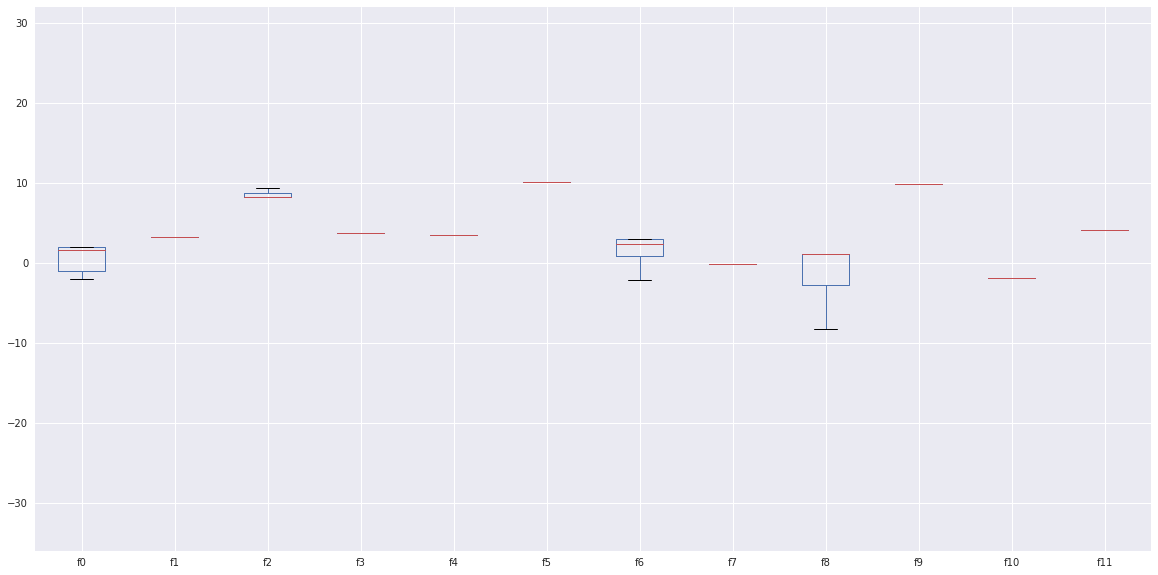

In [25]:
plt.figure(figsize = (20,10));
df_f.boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8b86fb7b8>,
      dtype=object)

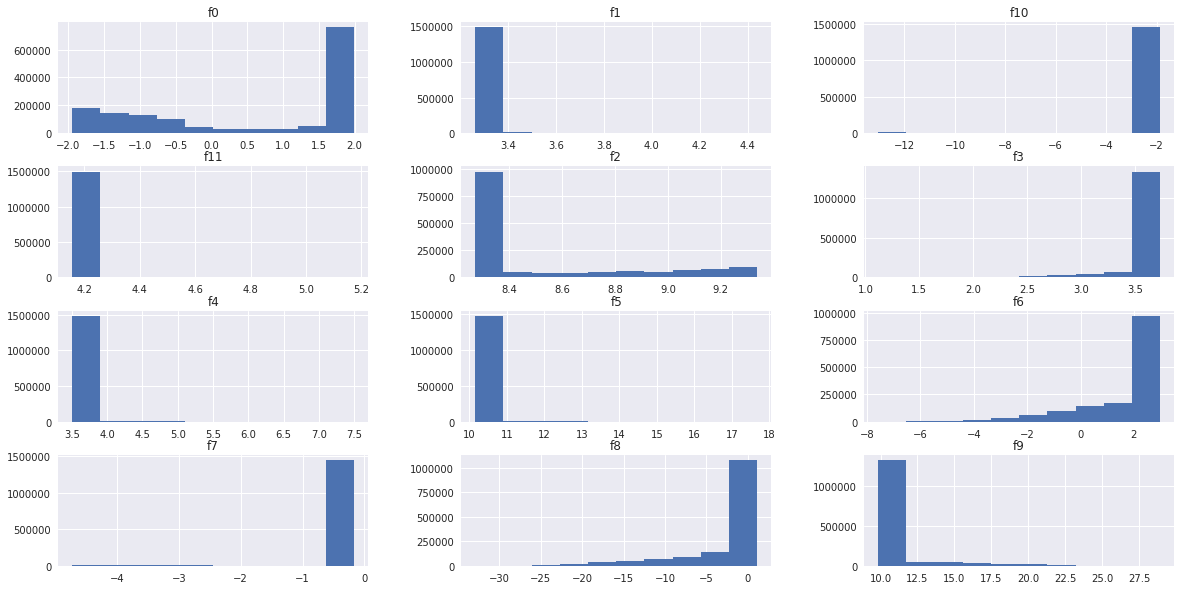

In [26]:
df_f.hist(figsize =(20,10))

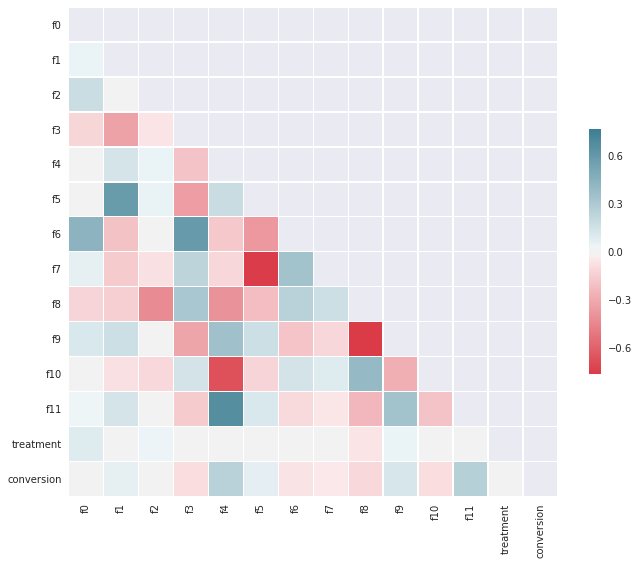

In [27]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10,220, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

###### Min-Max normalization of the dataset

In [28]:
df=(df-df.min())/(df.max()-df.min())
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion
0,0.689898,0.0,0.321814,0.899060,0.275493,0.0,0.847209,1.0,0.548730,0.369592,0.675873,0.280517,1.0,0.0
1,0.058286,0.0,0.000000,1.000000,0.000000,0.0,0.825770,1.0,1.000000,0.000000,1.000000,0.000000,1.0,0.0
2,0.658620,0.0,0.341726,0.840014,0.000000,0.0,0.847209,1.0,0.761137,0.272519,1.000000,0.000000,1.0,0.0
3,1.000000,0.0,0.000000,1.000000,0.000000,0.0,1.000000,1.0,1.000000,0.000000,1.000000,0.000000,1.0,0.0
4,0.225696,0.0,0.000000,1.000000,0.000000,0.0,0.847209,1.0,1.000000,0.000000,1.000000,0.000000,1.0,0.0


In [29]:
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion
count,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06
mean,6.520625e-01,1.698883e-03,2.203017e-01,9.696738e-01,3.971873e-03,5.388752e-03,8.841100e-01,9.719629e-01,9.070554e-01,4.317864e-02,9.792863e-01,1.424261e-03,8.461187e-01,2.282000e-03
std,3.896937e-01,1.945710e-02,3.371489e-01,9.224700e-02,2.733701e-02,3.090769e-02,1.583970e-01,1.463886e-01,1.608820e-01,1.204625e-01,1.236963e-01,1.671568e-02,3.608351e-01,4.771576e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.394027e-01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,8.071993e-01,1.000000e+00,8.875243e-01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,9.104697e-01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,9.436094e-01,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00,4.545190e-01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc885e97748>,
      dtype=object)

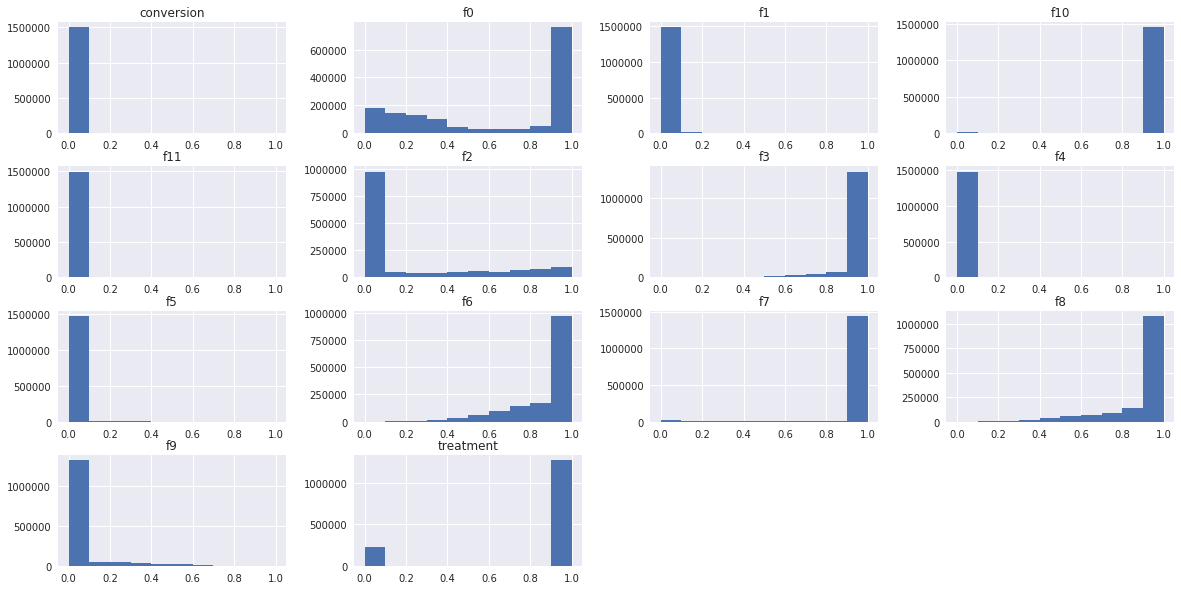

In [30]:
df.hist(figsize =(20,10))

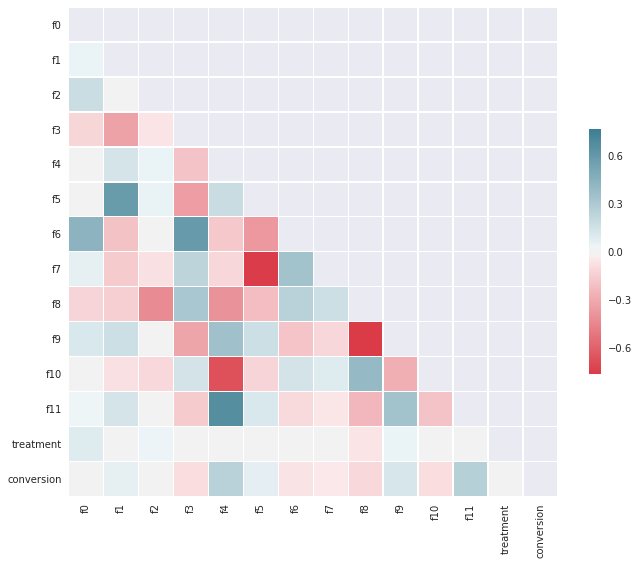

In [31]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10,220, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Two Model Approach

##### Setup test/train datasets

In [32]:
base = df[df.treatment == 0]
variant = df[df.treatment == 1]

delta = variant.conversion.mean() - base.conversion.mean()
delta_err = 1.96 * np.sqrt(variant.conversion.var() / variant.shape[0] + base.conversion.var() / base.shape[0])

print("Control: %s, N = %s, Conversion Rate: %s" % ( df[df.treatment == 0]['conversion'].sum() 
                               , df[df.treatment == 0].shape[0]
                               , df[df.treatment == 0]['conversion'].sum() / float(df[df.treatment == 0].shape[0]
     )))

print("Treatment: %s, N = %s, Conversion Rate: %s" % (df[df.treatment == 1]['conversion'].sum()
                            , df[df.treatment == 1].shape[0]
                            , df[df.treatment == 1]['conversion'].sum() / float(df[df.treatment == 1].shape[0]
     )))

print("")
print("Estimated Effect %s, Standard Error: %s" % (delta, delta_err))
print("")
lift = (variant.conversion.mean() - base.conversion.mean()) / base.conversion.mean()
print("Lift: %s" % lift)
print("")
t = stats.ttest_ind(df[df.treatment == 1]['conversion'], df[df.treatment == 0]['conversion'])
print("Test Statistic: %s, P-Value: %s" % (t[0], t[1]))

Control: 414.0, N = 230822, Conversion Rate: 0.001793589865784024
Treatment: 3009.0, N = 1269178, Conversion Rate: 0.0023708258416077176

Estimated Effect 0.0005772359758236935, Standard Error: 0.00019224109582323745

Lift: 0.3218327594482526

Test Statistic: 5.346256026256696, P-Value: 8.980524417256866e-08


In [33]:
# subset datasets
X_train_t, y_train_t = df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9',
                           'f10','f11']][df.treatment == 1],df['conversion'][df.treatment == 1]
X_train_c, y_train_c = df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9',
                           'f10','f11']][df.treatment == 0],df['conversion'][df.treatment == 0]

X_test, y_test = test[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9',
                           'f10','f11']],test[['conversion','treatment']]

In [35]:
print ("X_train_t Length: %s" % len(X_train_t))
print ("X_train_c Length: %s" % len(X_train_c))
print ("y_train_t Length: %s" % len(y_train_t))
print ("y_train_c Length: %s" % len(y_train_c))
print ("")
print ("y_test Length: %s" % len(y_test))
print ("y_test Length: %s" % len(y_test))

X_train_t Length: 1269178
X_train_c Length: 230822
y_train_t Length: 1269178
y_train_c Length: 230822

y_test Length: 500000
y_test Length: 500000


In [36]:
X_test.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
0,-0.599758,3.263641,8.272483,3.735871,3.506733,10.161281,0.945163,-0.166689,1.107571,9.850093,-1.8609,4.157648
1,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.8609,4.157648
2,1.991981,3.263641,9.279954,3.735871,3.506733,10.161281,2.981721,-0.166689,-0.584392,9.850093,-1.8609,4.157648
3,-1.819478,3.263641,8.272483,3.735871,3.506733,10.161281,1.367787,-0.166689,1.107571,9.850093,-1.8609,4.157648
4,1.991981,3.263641,8.885631,3.735871,3.506733,10.161281,2.981721,-0.166689,-6.006161,9.850093,-1.8609,4.157648


In [37]:
y_test.head()

,conversion,treatment
0,0,1
1,0,1
2,0,1
3,0,0
4,0,1


##### Run Models

In [43]:
# SVM Model

#Model setup
svm = LinearSVC(random_state=0, class_weight = 'balanced')
clf_svm= CalibratedClassifierCV(svm)

# treatment
fit_t_svm = clf_svm.fit(X_train_t, y_train_t)
pt_pred_svm = fit_t_svm.predict_proba(X_test)[:,1]
yt_pred_svm1 = fit_t_svm.predict(X_test)
yt_pred_svm = [round(value) for value in yt_pred_svm1]

accuracy = accuracy_score(y_test[['conversion']], yt_pred_svm)
print("Treatment Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test[['conversion']], yt_pred_svm))
print(confusion_matrix(y_test[['conversion']], yt_pred_svm))

# control
fit_c_svm = clf_svm.fit(X_train_c, y_train_c)
pc_pred_svm = fit_c_svm.predict_proba(X_test)[:,1]
yc_pred_svm1 = fit_c_svm.predict(X_test)
yc_pred_svm = [round(value) for value in yc_pred_svm1]

accuracy = accuracy_score(y_test[['conversion']], yc_pred_svm)
print("Control Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test[['conversion']], yc_pred_svm))
print(confusion_matrix(y_test[['conversion']], yc_pred_svm))

# uplift 
prob_t_svm = pd.DataFrame(pt_pred_svm)
prob_c_svm = pd.DataFrame(pc_pred_svm)
u_svm = pd.merge(prob_t_svm, prob_c_svm, left_index = True, right_index = True)
u_svm.columns = ['prob_t_svm','prob_c_svm']
u_svm['uplift_svm'] = prob_t_svm - prob_c_svm


Treatment Accuracy: 0.23%
             precision    recall  f1-score   support

          0       0.00      0.00      0.00    498837
          1       0.00      1.00      0.00      1163

avg / total       0.00      0.00      0.00    500000

[[     0 498837]
 [     0   1163]]
Treatment Accuracy: 83.84%
             precision    recall  f1-score   support

          0       1.00      0.84      0.91    498837
          1       0.01      0.80      0.02      1163

avg / total       1.00      0.84      0.91    500000

[[418287  80550]
 [   233    930]]


In [44]:
# results dataframe
results1 = pd.merge(y_test, u_svm, left_index=True, right_index=True)

In [45]:
results1.head()

,conversion,treatment,prob_t_svm,prob_c_svm,uplift_svm
0,0,1,1.0,0.000006,0.999994
1,0,1,1.0,0.000014,0.999986
2,0,1,1.0,0.000095,0.999905
3,0,0,1.0,0.000001,0.999999
4,0,1,1.0,0.295128,0.704872


In [46]:
# Logistic Regression

# grid search paramaters
params = {'C':[1, 10, 100]}

#Model setup
lr=LogisticRegression(random_state=0, class_weight='balanced')
clf_lr= GridSearchCV(lr, params)

# treatment
fit_t_lr = clf_lr.fit(X_train_t, y_train_t)
print('Best Treatment Parameters:', fit_t_lr.best_params_)
pt_pred_lr = fit_t_lr.predict_proba(X_test)[:,1]
yt_pred_lr1 = fit_t_lr.predict(X_test)
yt_pred_lr = [round(value) for value in yt_pred_lr1]

accuracy = accuracy_score(y_test[['conversion']], yt_pred_lr)
print("Treatment Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test[['conversion']], yt_pred_lr))
print(confusion_matrix(y_test[['conversion']], yt_pred_lr))

# control
fit_c_lr = clf_lr.fit(X_train_c, y_train_c)
print('Best Control Parameters:', fit_c_lr.best_params_)
pc_pred_lr = fit_c_lr.predict_proba(X_test)[:,1]
yc_pred_lr1 = fit_c_lr.predict(X_test)
yc_pred_lr = [round(value) for value in yc_pred_lr1]

accuracy = accuracy_score(y_test[['conversion']], yc_pred_lr)
print("Control Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test[['conversion']], yc_pred_lr))
print(confusion_matrix(y_test[['conversion']], yc_pred_lr))

# uplift 
prob_t_lr = pd.DataFrame(pt_pred_lr)
prob_c_lr = pd.DataFrame(pc_pred_lr)
u_lr = pd.merge(prob_t_lr, prob_c_lr, left_index = True, right_index = True)
u_lr.columns = ['prob_t_lr','prob_c_lr']
u_lr['uplift_lr'] = prob_t_lr - prob_c_lr

Best Treatment Parameters: {'C': 10}
Treatment Accuracy: 0.23%
             precision    recall  f1-score   support

          0       0.00      0.00      0.00    498837
          1       0.00      1.00      0.00      1163

avg / total       0.00      0.00      0.00    500000

[[     0 498837]
 [     0   1163]]
Best Control Parameters: {'C': 1}
Control Accuracy: 87.66%
             precision    recall  f1-score   support

          0       1.00      0.88      0.93    498837
          1       0.01      0.77      0.03      1163

avg / total       1.00      0.88      0.93    500000

[[437414  61423]
 [   262    901]]


In [47]:
# results dataframe
results2 = pd.merge(results1, u_lr, left_index=True, right_index=True)

In [48]:
results2.head()

,conversion,treatment,prob_t_svm,prob_c_svm,uplift_svm,prob_t_lr,prob_c_lr,uplift_lr
0,0,1,1.0,0.000006,0.999994,1.0,2.314669e-20,1.000000
1,0,1,1.0,0.000014,0.999986,1.0,1.561584e-17,1.000000
2,0,1,1.0,0.000095,0.999905,1.0,1.003930e-15,1.000000
3,0,0,1.0,0.000001,0.999999,1.0,2.029887e-22,1.000000
4,0,1,1.0,0.295128,0.704872,1.0,7.142667e-06,0.999993


In [53]:
# Random Forest

# grid search paramaters
params = {
    'n_estimators': [30,40,50] ,
    'max_depth': [10,20,30],
    'max_features': [2, 3]
}

#Model setup
rf = RandomForestClassifier(random_state=0, class_weight = 'balanced')
clf_rf= RandomizedSearchCV(rf, params)

# treatment
fit_t_rf = clf_rf.fit(X_train_t, y_train_t)
print('Best Treatment Parameters:', fit_t_rf.best_params_)
pt_pred_rf = fit_t_rf.predict_proba(X_test)[:,1]
yt_pred_rf1 = fit_t_rf.predict(X_test)
yt_pred_rf = [round(value) for value in yt_pred_rf1]

accuracy = accuracy_score(y_test[['conversion']], yt_pred_rf)
print("Treatment Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test[['conversion']], yt_pred_rf))
print(confusion_matrix(y_test[['conversion']], yt_pred_rf))

# control
fit_c_rf = clf_rf.fit(X_train_c, y_train_c)
print('Best Control Parameters:', fit_c_rf.best_params_)
pc_pred_rf = fit_c_rf.predict_proba(X_test)[:,1]
yc_pred_rf1 = fit_c_rf.predict(X_test)
yc_pred_rf = [round(value) for value in yc_pred_rf1]

accuracy = accuracy_score(y_test[['conversion']], yc_pred_rf)
print("Control Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test[['conversion']], yc_pred_rf))
print(confusion_matrix(y_test[['conversion']], yc_pred_rf))
      
# uplift 
prob_t_rf = pd.DataFrame(pt_pred_rf)
prob_c_rf = pd.DataFrame(pc_pred_rf)
u_rf = pd.merge(prob_t_rf, prob_c_rf, left_index = True, right_index = True)
u_rf.columns = ['prob_t_rf','prob_c_rf']
u_rf['uplift_rf'] = prob_t_rf - prob_c_rf

Best Treatment Parameters: {'max_features': 2, 'n_estimators': 50, 'max_depth': 30}
Treatment Accuracy: 99.77%
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    498837
          1       0.00      0.00      0.00      1163

avg / total       1.00      1.00      1.00    500000

[[498837      0]
 [  1163      0]]
Best Control Parameters: {'max_features': 2, 'n_estimators': 50, 'max_depth': 30}
Control Accuracy: 99.77%
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    498837
          1       0.00      0.00      0.00      1163

avg / total       1.00      1.00      1.00    500000

[[498837      0]
 [  1163      0]]


In [54]:
# results dataframe
results3 = pd.merge(results2, u_rf, left_index=True, right_index=True)

In [55]:
results3.head()

,conversion,treatment,prob_t_svm,prob_c_svm,uplift_svm,prob_t_lr,prob_c_lr,uplift_lr,prob_t_rf,prob_c_rf,uplift_rf
0,0,1,1.0,0.000006,0.999994,1.0,2.314669e-20,1.000000,0.0,0.00,0.00
1,0,1,1.0,0.000014,0.999986,1.0,1.561584e-17,1.000000,0.0,0.00,0.00
2,0,1,1.0,0.000095,0.999905,1.0,1.003930e-15,1.000000,0.0,0.02,-0.02
3,0,0,1.0,0.000001,0.999999,1.0,2.029887e-22,1.000000,0.0,0.00,0.00
4,0,1,1.0,0.295128,0.704872,1.0,7.142667e-06,0.999993,0.0,0.02,-0.02


In [58]:
# XGBoost

# grid search paramaters
params = {
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'gamma': [0.5, 1, 1.5]
}

#Model setup

spw=(y_train_t.shape[0] - y_train_t.sum()) / y_train_t.sum()
xg = xgboost.XGBClassifier(scale_pos_weight=spw)
clf_xg= RandomizedSearchCV(xg, params)

# treatment
fit_t_xg = clf_xg.fit(X_train_t, y_train_t)
print('Best Treatment Parameters:', fit_t_xg.best_params_)
pt_pred_xg = fit_t_xg.predict_proba(X_test)[:,1]
yt_pred_xg1 = fit_t_xg.predict(X_test)
yt_pred_xg = [round(value) for value in yt_pred_xg1]

accuracy = accuracy_score(y_test[['conversion']], yt_pred_xg)
print("Treatment Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test[['conversion']], yt_pred_xg))
print(confusion_matrix(y_test[['conversion']], yt_pred_xg))

# control
fit_c_xg = clf_xg.fit(X_train_c, y_train_c)
print('Best Control Parameters:', fit_c_xg.best_params_)
pc_pred_xg = fit_c_xg.predict_proba(X_test)[:,1]
yc_pred_xg1 = fit_c_xg.predict(X_test)
yc_pred_xg = [round(value) for value in yc_pred_xg1]

accuracy = accuracy_score(y_test[['conversion']], yc_pred_xg)
print("Control Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test[['conversion']], yc_pred_xg))
print(confusion_matrix(y_test[['conversion']], yc_pred_xg))

# uplift 
prob_t_xg = pd.DataFrame(pt_pred_xg)
prob_c_xg = pd.DataFrame(pc_pred_xg)
u_xg = pd.merge(prob_t_xg, prob_c_xg, left_index = True, right_index = True)
u_xg.columns = ['prob_t_xg','prob_c_xg']
u_xg['uplift_xg'] = prob_t_xg - prob_c_xg
      

Best Treatment Parameters: {'min_child_weight': 3, 'max_depth': 7, 'gamma': 1.5}
Treatment Accuracy: 99.77%
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    498837
          1       0.00      0.00      0.00      1163

avg / total       1.00      1.00      1.00    500000

[[498837      0]
 [  1163      0]]
Best Control Parameters: {'min_child_weight': 1, 'max_depth': 7, 'gamma': 1.5}
Control Accuracy: 99.77%
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    498837
          1       0.00      0.00      0.00      1163

avg / total       1.00      1.00      1.00    500000

[[498837      0]
 [  1163      0]]


In [59]:
results4 = pd.merge(results3, u_xg, left_index=True, right_index=True)

In [60]:
results4.head()

,conversion,treatment,prob_t_svm,prob_c_svm,uplift_svm,prob_t_lr,prob_c_lr,uplift_lr,prob_t_rf,prob_c_rf,uplift_rf,prob_t_xg,prob_c_xg,uplift_xg
0,0,1,1.0,0.000006,0.999994,1.0,2.314669e-20,1.000000,0.0,0.00,0.00,0.000001,0.000349,-0.000348
1,0,1,1.0,0.000014,0.999986,1.0,1.561584e-17,1.000000,0.0,0.00,0.00,0.000011,0.000111,-0.000099
2,0,1,1.0,0.000095,0.999905,1.0,1.003930e-15,1.000000,0.0,0.02,-0.02,0.000074,0.001894,-0.001820
3,0,0,1.0,0.000001,0.999999,1.0,2.029887e-22,1.000000,0.0,0.00,0.00,0.000001,0.000349,-0.000348
4,0,1,1.0,0.295128,0.704872,1.0,7.142667e-06,0.999993,0.0,0.02,-0.02,0.000074,0.001894,-0.001820


##### Evaluation

In [70]:
result = results4

In [71]:
test = results4

Logistic Regression q1 qini score:  -0.17676485475747333


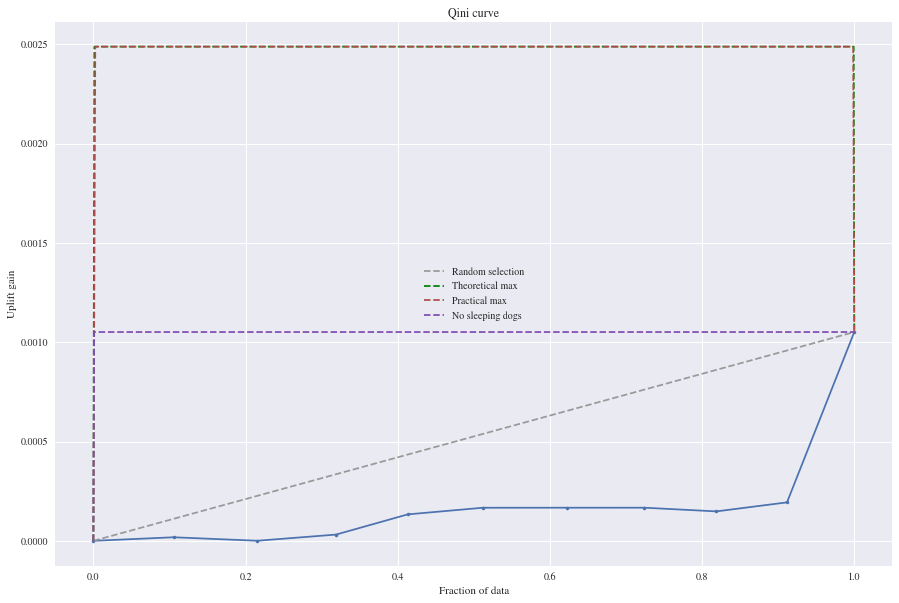

In [73]:
#Logistic Regression
test = test.sort_values(by=['uplift_lr'], ascending=False)
uplev_lr = UpliftEval(test['treatment'], test['conversion'], test['uplift_lr'] , n_bins=10)
print("Logistic Regression q1 qini score: ", uplev_lr.q1_qini)
uplev_lr.plot(plot_type='qini',show_practical_max=True, show_no_dogs=True, show_theoretical_max=True)

SVM q1 qini score:  -0.20329364238046116


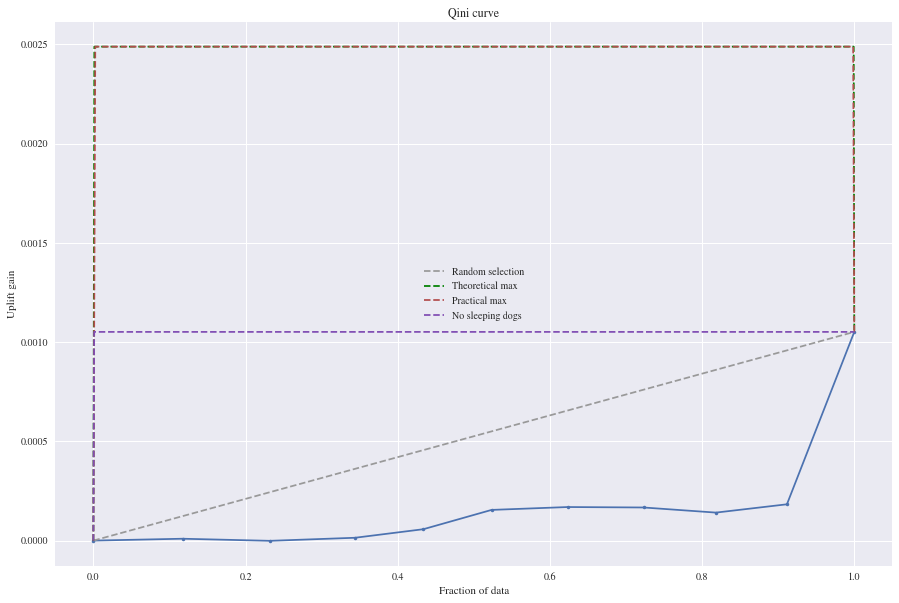

In [72]:
#SVM
test = test.sort_values(by=['uplift_svm'], ascending=False)
uplev_svm = UpliftEval(test['treatment'], test['conversion'], test['uplift_svm'] , n_bins=10)
print("SVM q1 qini score: ", uplev_svm.q1_qini)
uplev_svm.plot(plot_type='qini',show_practical_max=True, show_no_dogs=True, show_theoretical_max=True)

Random Forest q1 qini score:  -0.10145719763203817


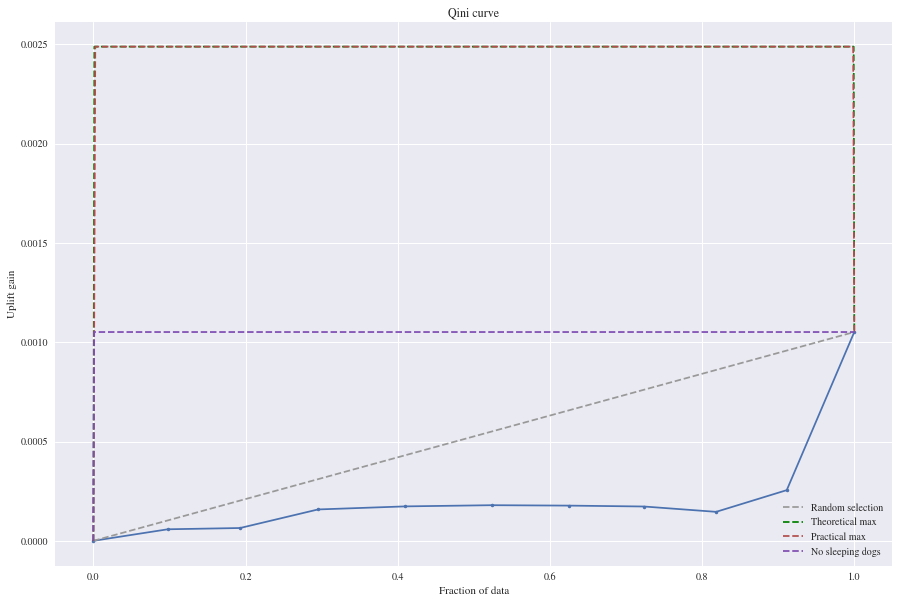

In [76]:
# Random Forest
test = test.sort_values(by=['uplift_rf'], ascending=False)
uplev_rf = UpliftEval(test['treatment'], test['conversion'], test['uplift_rf'] , n_bins=10)
print("Random Forest q1 qini score: ", uplev_rf.q1_qini)
uplev_rf.plot(plot_type='qini',show_practical_max=True, show_no_dogs=True, show_theoretical_max=True)

XGBoost q1 qini score:  -0.040610126692445354


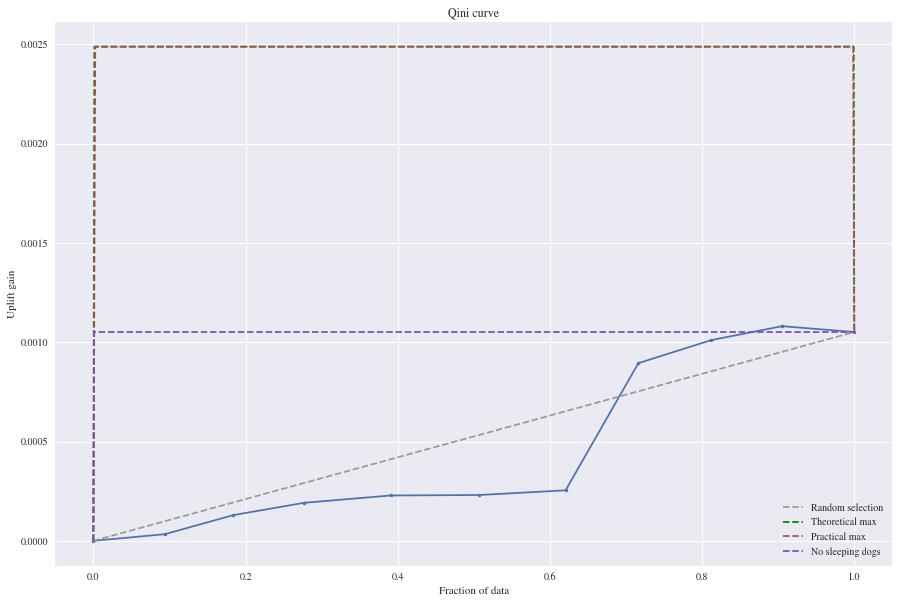

In [77]:
#XGBoost
test = test.sort_values(by=['uplift_xg'], ascending=False)
uplev_xg = UpliftEval(test['treatment'], test['conversion'], test['uplift_xg'] , n_bins=10)
print("XGBoost q1 qini score: ", uplev_xg.q1_qini)
uplev_xg.plot(plot_type='qini',show_practical_max=True, show_no_dogs=True, show_theoretical_max=True)

#### Save Results file in storage

In [80]:
result.to_csv('results.csv', index = False)
!gsutil cp 'results.csv' 'gs://fit-reference-229502/results.csv'



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://results.csv [Content-Type=text/csv]...
- [1 files][ 70.8 MiB/ 70.8 MiB]                                                
Operation completed over 1 objects/70.8 MiB.                                     


In [82]:
from io import BytesIO
%gcs read --object gs://fit-reference-229502/results.csv --variable results_file
df2 = pd.read_csv(BytesIO(results_file))

In [83]:
df2.head()

,conversion,treatment,prob_t_svm,prob_c_svm,uplift_svm,prob_t_lr,prob_c_lr,uplift_lr,prob_t_rf,prob_c_rf,uplift_rf,prob_t_xg,prob_c_xg,uplift_xg
0,0,1,1.0,0.000006,0.999994,1.0,2.314669e-20,1.000000,0.0,0.00,0.00,0.000001,0.000349,-0.000348
1,0,1,1.0,0.000014,0.999986,1.0,1.561584e-17,1.000000,0.0,0.00,0.00,0.000011,0.000111,-0.000099
2,0,1,1.0,0.000095,0.999905,1.0,1.003930e-15,1.000000,0.0,0.02,-0.02,0.000074,0.001894,-0.001820
3,0,0,1.0,0.000001,0.999999,1.0,2.029887e-22,1.000000,0.0,0.00,0.00,0.000001,0.000349,-0.000348
4,0,1,1.0,0.295128,0.704872,1.0,7.142667e-06,0.999993,0.0,0.02,-0.02,0.000074,0.001894,-0.001820
